# Problem Statement: **AtliQ's Customer Churn Prediction**

### Welcome to AtliQ Electronics, a leading consumer electronics retailer! AtliQ has been facing customer churn issues and is building an AI-powered predictive model to identify customers likely to discontinue their services. However, the data science team observed that the model tends to overfit the training data, leading to poor generalization on new data. Your task is to implement and compare different regularization techniques to build a robust and accurate churn prediction model.



Imports and CUDA

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Let's do some revisoin first and test your basic understanding of this module!

Problem1: **Effect of L1 Regularization on Sparsity in AtliQ's AI Models**

AtliQ is optimizing its AI models to reduce unnecessary complexity. You are given the following weights from one of AtliQ's neural network layers:



```
weights = torch.tensor([0.5, -0.3, 0.8, -1.5], requires_grad=True)
```

Write a PyTorch snippet to compute the L1 regularization term ``` (|w1| + |w2| + ...) ``` and calculate its gradient using backward().


In [ ]:
# weights
weights = torch.tensor([0.5, -0.3, 0.8, -1.5], requires_grad=True)

# Compute L1 regularization term
l1_regularization = torch.sum(torch.abs(weights))

# compute gradients
l1_regularization.backward()

# Output gradients
print(f"L1 Regularization: {l1_regularization.item():.4f}")
print(f"Gradients: {weights.grad}")

L1 Regularization: 3.1000
Gradients: tensor([ 1., -1.,  1., -1.])




---



Problem2: **Batch Normalization of AtliQ's Marketing Data**

AtliQ has collected a mini-batch of marketing data:

`inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])`

Manually implement the forward pass of Batch Normalization. Normalize the data using:

$$Normalized= X-μ / σ$$

Here, μ is the mean of each feature, and σ is the standard deviation.

Write code to compute the normalized data without using `nn.BatchNorm`.





In [ ]:
# inputs
inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])

# compute mean and standard deviation along each column (feature)
mean = inputs.mean(dim=0)
std = inputs.std(dim=0)

# normalize the inputs
normalized = (inputs - mean) / std

print(f"Inputs:\n{inputs}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Normalized Outputs:\n{normalized}")

Inputs:
tensor([[10., 20.],
        [15., 25.],
        [12., 18.]])
Mean: tensor([12.3333, 21.0000])
Standard Deviation: tensor([2.5166, 3.6056])
Normalized Outputs:
tensor([[-0.9272, -0.2774],
        [ 1.0596,  1.1094],
        [-0.1325, -0.8321]])




---



### Task: **AtliQ's Customer Churn Prediction**



**Dataset Description**

You are provided with 5000 customer records and 6 features that describe customer behavior over the past 12 months. The provided dataset (**AtliQ_Churn_Prediction_Codebasics_DL.csv)** includes the following attributes:

* Purchase_History
* Support_Tickets
* Last_Purchase_Months
* Product_Categories
* Satisfaction_Score
* Discount_Usage_Rate

Target Variable:

* Churned: 1 if the customer has churned, 0 otherwise.

**Step1**: Load and Prepare the Dataset

In [ ]:
# Load dataset
data = pd.read_csv("/content/AtliQ_Churn_Prediction_Codebasics_DL.csv")

# Separate features and target
X = data.drop("Churned", axis=1).values
y = data["Churned"].values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Purchase_History      5000 non-null   int64  
 1   Support_Tickets       5000 non-null   int64  
 2   Last_Purchase_Months  5000 non-null   int64  
 3   Product_Categories    5000 non-null   int64  
 4   Satisfaction_Score    5000 non-null   float64
 5   Discount_Usage_Rate   5000 non-null   float64
 6   Churned               5000 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 273.6 KB




---



**Step2**: Split the Dataset

Train : Test :: 70 : 30



---



In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




---



**Step3**: Normalize the features



In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



---



**Step4**: Convert to PyTorch Tensors

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



---



**Step5**: Build a Base Model (without regularization)

Details:
* Input layer: 6 features
* Hidden layers: Two layers with 32 and 16 neurons (ReLU activation)
* Output layer: 1 neuron (Sigmoid activation for binary classification)
* Train for 30 epochs, batch size = 32, learning rate = 0.01.
* Use **BCELoss** and **SGD** as Optimizer

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.network = nn.Sequential(
           nn.Linear(6, 32),
           nn.ReLU(),
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, 1),
           nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

model = BaseModel()
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)




---



**Step6**: Train the Base Model

* epochs = 30
* batch size = 32

Epoch 1, Training Loss: 0.6561, Validation Loss: 0.6368
Epoch 2, Training Loss: 0.6295, Validation Loss: 0.6207
Epoch 3, Training Loss: 0.6203, Validation Loss: 0.6154
Epoch 4, Training Loss: 0.6175, Validation Loss: 0.6138
Epoch 5, Training Loss: 0.6166, Validation Loss: 0.6133
Epoch 6, Training Loss: 0.6162, Validation Loss: 0.6130
Epoch 7, Training Loss: 0.6160, Validation Loss: 0.6129
Epoch 8, Training Loss: 0.6158, Validation Loss: 0.6128
Epoch 9, Training Loss: 0.6156, Validation Loss: 0.6128
Epoch 10, Training Loss: 0.6154, Validation Loss: 0.6127
Epoch 11, Training Loss: 0.6152, Validation Loss: 0.6127
Epoch 12, Training Loss: 0.6151, Validation Loss: 0.6126
Epoch 13, Training Loss: 0.6149, Validation Loss: 0.6126
Epoch 14, Training Loss: 0.6148, Validation Loss: 0.6126
Epoch 15, Training Loss: 0.6147, Validation Loss: 0.6126
Epoch 16, Training Loss: 0.6146, Validation Loss: 0.6126
Epoch 17, Training Loss: 0.6145, Validation Loss: 0.6126
Epoch 18, Training Loss: 0.6144, Validat

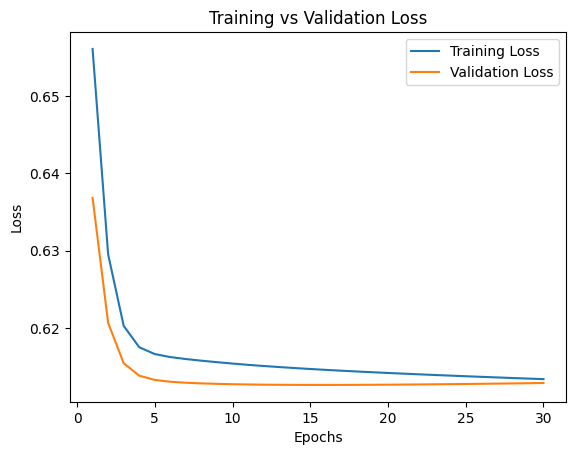

In [ ]:
# Train the model
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

**Key Insights**

* Both training and validation loss curves show healthy convergence, decreasing smoothly without erratic behavior, indicating stable learning.



---



**Step7**: Implement Dropout Regularization

Modify the base model to include dropout layers after each dense layer.
* Experiment with dropout rate 0.4.

In [ ]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

dropout_model = DropoutModel()
optimizer_dropout = optim.SGD(dropout_model.parameters(), lr=0.01)




---



**Step8**: Training Process for Dropout Regularization

Epoch 1, Training Loss: 0.7098, Validation Loss: 0.6724
Epoch 2, Training Loss: 0.6569, Validation Loss: 0.6394
Epoch 3, Training Loss: 0.6343, Validation Loss: 0.6251
Epoch 4, Training Loss: 0.6279, Validation Loss: 0.6192
Epoch 5, Training Loss: 0.6218, Validation Loss: 0.6168
Epoch 6, Training Loss: 0.6233, Validation Loss: 0.6157
Epoch 7, Training Loss: 0.6220, Validation Loss: 0.6150
Epoch 8, Training Loss: 0.6193, Validation Loss: 0.6146
Epoch 9, Training Loss: 0.6229, Validation Loss: 0.6143
Epoch 10, Training Loss: 0.6176, Validation Loss: 0.6139
Epoch 11, Training Loss: 0.6209, Validation Loss: 0.6137
Epoch 12, Training Loss: 0.6187, Validation Loss: 0.6135
Epoch 13, Training Loss: 0.6206, Validation Loss: 0.6134
Epoch 14, Training Loss: 0.6183, Validation Loss: 0.6131
Epoch 15, Training Loss: 0.6178, Validation Loss: 0.6129
Epoch 16, Training Loss: 0.6174, Validation Loss: 0.6128
Epoch 17, Training Loss: 0.6178, Validation Loss: 0.6127
Epoch 18, Training Loss: 0.6161, Validat

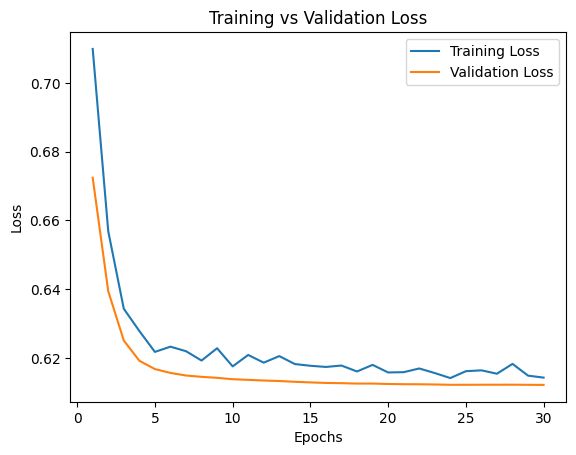

In [ ]:
# Train the model for Dropout Regularization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    dropout_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_dropout.zero_grad()
        y_pred = dropout_model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_dropout.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    dropout_model.eval()
    with torch.no_grad():
        val_predictions = dropout_model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

**Key Insight**:

The addition of dropout (40%) introduces noticeable fluctuations in the training loss curve compared to the baseline model, which is expected as dropout randomly deactivates neurons during training. Despite these fluctuations, the validation loss remains smoother and consistently lower than the training loss, indicating that dropout is effectively preventing overfitting.



---



**Step9**: Apply L2 Regularization

* Use `torch.optim.SGD` with `weight_decay=0.1` for L2 regularization.
* Train the model and monitor validation loss and accuracy.

Epoch 1, Training Loss: 0.6140, Validation Loss: 0.6142
Epoch 2, Training Loss: 0.6159, Validation Loss: 0.6158
Epoch 3, Training Loss: 0.6176, Validation Loss: 0.6169
Epoch 4, Training Loss: 0.6188, Validation Loss: 0.6176
Epoch 5, Training Loss: 0.6196, Validation Loss: 0.6182
Epoch 6, Training Loss: 0.6202, Validation Loss: 0.6186
Epoch 7, Training Loss: 0.6207, Validation Loss: 0.6189
Epoch 8, Training Loss: 0.6210, Validation Loss: 0.6191
Epoch 9, Training Loss: 0.6213, Validation Loss: 0.6193
Epoch 10, Training Loss: 0.6215, Validation Loss: 0.6194
Epoch 11, Training Loss: 0.6216, Validation Loss: 0.6195
Epoch 12, Training Loss: 0.6217, Validation Loss: 0.6195
Epoch 13, Training Loss: 0.6218, Validation Loss: 0.6196
Epoch 14, Training Loss: 0.6218, Validation Loss: 0.6196
Epoch 15, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 16, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 17, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 18, Training Loss: 0.6219, Validat

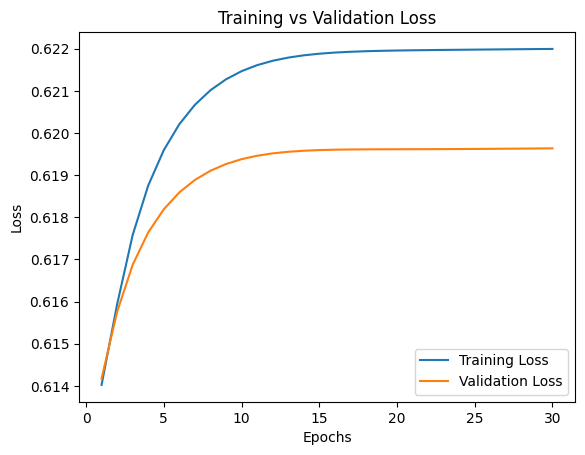

In [ ]:
# L2 regularization (weight decay)
optimizer_l2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

# Train the model for L2 Regularization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train() # model will remain the same
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_l2.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_l2.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


**Key Insights**:

The L2 regularization plot shows concerning behavior where both training and validation losses are increasing over time, indicating the model is diverging from the optimal solution rather than converging to it. This divergent behavior suggests the L2 regularization strength (weight decay) might be too aggressive, penalizing the weights too heavily and preventing the model from finding the optimal minimum.



---



**Step10**: Add Batch Normalization

* use BatchNorm1d
* use **SGD** Optimizer with learning rate = 0.01

In [ ]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Train the BatchNormModel
batchnorm_model = BatchNormModel()
optimizer_bn = optim.SGD(batchnorm_model.parameters(), lr=0.01)




---



**Step11**: Training Process for Batch Normalization

Epoch 1, Training Loss: 0.6685, Validation Loss: 0.6451
Epoch 2, Training Loss: 0.6350, Validation Loss: 0.6307
Epoch 3, Training Loss: 0.6261, Validation Loss: 0.6258
Epoch 4, Training Loss: 0.6219, Validation Loss: 0.6232
Epoch 5, Training Loss: 0.6193, Validation Loss: 0.6215
Epoch 6, Training Loss: 0.6174, Validation Loss: 0.6202
Epoch 7, Training Loss: 0.6160, Validation Loss: 0.6193
Epoch 8, Training Loss: 0.6149, Validation Loss: 0.6186
Epoch 9, Training Loss: 0.6140, Validation Loss: 0.6181
Epoch 10, Training Loss: 0.6132, Validation Loss: 0.6177
Epoch 11, Training Loss: 0.6125, Validation Loss: 0.6174
Epoch 12, Training Loss: 0.6119, Validation Loss: 0.6172
Epoch 13, Training Loss: 0.6113, Validation Loss: 0.6172
Epoch 14, Training Loss: 0.6107, Validation Loss: 0.6172
Epoch 15, Training Loss: 0.6103, Validation Loss: 0.6172
Epoch 16, Training Loss: 0.6098, Validation Loss: 0.6172
Epoch 17, Training Loss: 0.6094, Validation Loss: 0.6173
Epoch 18, Training Loss: 0.6090, Validat

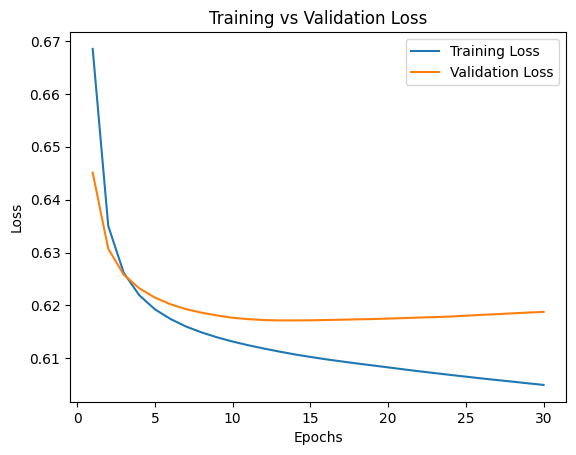

In [ ]:
# Train the model for Batch Normalization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    batchnorm_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_bn.zero_grad()
        y_pred = batchnorm_model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_bn.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    batchnorm_model.eval()
    with torch.no_grad():
        val_predictions = batchnorm_model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


**Key Insights**:

After an initial sharp decline in both losses, we observe a clear sign of overfitting where the training loss (blue) continues to decrease while validation loss (orange) starts to plateau and slightly increase after epoch 15.



---

